In [2]:
#will go into .gitignore
import numpy as np
import json 
import logging
import matplotlib.pyplot as plt

In [2]:

logging.basicConfig(filename='log',level=logging.DEBUG)
#numpy writer::
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
def loss_cal(prob,i,j,state): #i is position of last query, j is last state at which we need loss
    
    n=prob.shape[1]
    loss = np.zeros((n,1));
    # print(loss.shape)
    for x in range(j-i):
        temp = np.reshape(np.min(np.linalg.matrix_power(prob,x+1),axis=1),(2,1))
        # print(temp.shape)
        loss+= temp
    return np.matmul(state,loss)

def query_loss(i,j,res,prob):
        #this is a quey to return loss from i-j inclusive if a query is made given outcome
        state_curr=np.array([[1-res],[res]])
        loss=0
        for idx in range(i+1,j+1):
            state_curr = np.matmul(prob,state_curr)
            loss+=np.min(state_curr)
        # print("I: ",i,"J: ",j,"LOSS: ",loss)
        return loss

def write_file(fp,json_obj):
    json_=json.dumps(json_obj,indent=4,cls=NumpyEncoder)
    with open(fp,'a') as f:
        f.write(json_)

def write_log(log,type='info'):
    if(type=='info'):
        logging.info(log)
    elif(type=='debug'):
        logging.debug(log)
    elif(type=='warning'):
        logging.warning(log)
    elif(type=='error'):
        logging.error(log)
    elif(type=='critical'):
        logging.critical(log)


def read_ndjson(fp):
    json_str=""
    arr=[]
    with open(fp) as f:
        for line in f:
            if(line[0]=='}' and line[1]=='{'):
                arr.append(json.loads(json_str))
                json_str="{"
            else:
                json_str+=line
    return arr

In [3]:
def OPTPolicy(prob,T,cost):
    n = prob.shape[0]
    
    dp = np.zeros((T+1,n)) # dp_ik is the position to query next if previous query was at i and result was state k   
    loss = np.zeros((T+1,n)) # Expected loss till the end of the horizon
    for i in range(n):
        dp[T][i]=np.inf
        loss[T][i]=0

    for i in range(T-1,-1,-1):
        for k in range(n):
            state = np.zeros((1,n))
            state[0,k]=1
            curr=loss_cal(prob,i,T,state)
            dp[i,k]=np.inf
            for x in range(i+1,T+1):
                new_curr = loss_cal(prob,i,x-1,state) + cost
                
                state = np.matmul(state,np.linalg.matrix_power(prob,x-i))
                for s in range(n):
                    new_curr += loss[x,s]*state[0,s]

                if new_curr < curr:
                    curr=new_curr
                    dp[i,k]=x
                    
            loss[i,k]=curr
            
    return loss[0,0]
        
def DP(mdp_history,prob,cost,k_max=100):
    horizon=np.size(mdp_history)
    arr=np.zeros((horizon,k_max+1,horizon))+np.inf# DP array i,j,k represents min cost of [0-i] with j vals and last probe at k::

    for i in range(horizon):
        print(f"{i}/{horizon}")
        for k in range(i+1):
            for j in range(min(k+2,k_max+1)):
                if(j==0):
                    arr[i,j,k]=query_loss(0,i,mdp_history[0],prob)
                elif(k==i):
                    if(i==0):
                        arr[i,j,k]=min(arr[i,j,k],0+cost)
                    else:
                        arr[i,j,k]=min(arr[i,j,k],np.min(arr[i-1,j-1,max(j-2,0):i])+cost)
                elif(k<i):
                    arr[i,j,k]=min(arr[i,j,k],arr[k,j,k]+query_loss(k,i,mdp_history[k],prob))
            #k_max=int(np.min(arr[arr>=0])//cost)#updating k_max at the end of each iteration::# can be improvised
    best_loss=(np.min(arr[horizon-1,:,:]))
    #=print(best_loss)
    return best_loss

In [4]:
class Simulator:
    def __init__(self, prob, state, horizon, cost):
        self.prob = prob
        self.state = state
        self.horizon = horizon
        self.cost = cost
        self.num = prob.shape[0]  #number of states
        self.history=[state]
    def next(self):
        tr=np.random.rand()
        
        tot=0.0
        
        for i in range(self.num):
            if tr<=tot+self.prob[self.state][i]:
                self.history.append(i)
                return i
            else:
                tot+=self.prob[self.state][i]
        #write_log(f"tr:{tr},tot:{tot}")

    def simulate(self):
        
            
        for step in range(self.horizon):
            self.state = self.next()
            
        
        return np.array(self.history)


In [5]:
def test_algo(algo_arr,test_cases=None):
    #tests against all the algoriths provided:: in the algo arr against THE conjectured algorithm::
    if(test_cases is None):
        test_cases=[]
        for i in range(50):
            dict_test_case={}
            p1=np.random.rand()
            p2=np.random.rand()
            dict_test_case['prob']=np.array([[p1,1-p1],[p2,1-p2]])
            dict_test_case['T']=10*np.random.randint(1,20)
            dict_test_case['cost']=3*np.random.rand()
            test_cases.append(dict_test_case)
     
    for test_case in test_cases:
            #making a history obj that will be stored in a file:: for graphs and evaluation::
            loss=0
            for i in range(100):
                 sim = Simulator(test_case['prob'],0,test_case['T'],test_case['cost'])
                 history=sim.simulate()

                 loss_p_case=DP(history,test_case['prob'],test_case['cost'])
                 loss+=loss_p_case
            print(f"expected DP loss:{loss/100}\n loss from algo: {OPTPolicy(test_case['prob'],test_case['T'],test_case['cost'])}")

In [74]:
#test_algo([])   
#formulating problem as constraint minimization problem::
def get_l(state,alpha,prob,cost):
    loss=0
    mtx=np.array([1-state, state])
    for i in range(alpha-1):
        mtx=np.matmul(mtx,prob)
        loss+= np.min(mtx)
    mtx=np.matmul(mtx,prob)
    return loss+cost,mtx
Mx_val=110
arr=np.zeros((Mx_val,Mx_val))
prob=np.array([[0.03605564, 0.96394436],
       [0.66549118, 0.33450882]]) 
cost=0.4907096532695946
for i in range(1,Mx_val+1):
    for j in range(1,Mx_val+1):
        alpha_l,P_0=get_l(0,i,prob,cost)
        beta_l,P_1=get_l(1,j,prob,cost)
        v=(alpha_l*P_1[0]+P_0[1]*beta_l)/(i*P_1[0]+j*P_0[1])
        arr[i-1,j-1]=v
        #print(v,end=" ")
    #print("")
res=np.unravel_index(np.argmin(arr),arr.shape)
print(arr)
alpha=res[0]+1
beta=res[1]+1
print(f"alpha:{alpha} \nbeta:{beta}")
def get_cost(alpha,beta,prob,cost):
    alpha_l,P_0=get_l(0,alpha,prob,cost)
    beta_l,P_1=get_l(1,beta,prob,cost)
    v=(alpha_l*P_1[0]+P_0[1]*beta_l)/(alpha*P_1[0]+beta*P_0[1])
    return v,alpha_l,beta_l

    

[[0.49070965 0.42146653 0.37728858 ... 0.40771182 0.40771827 0.40772461]
 [0.3114828  0.35166238 0.31147506 ... 0.40440035 0.40443645 0.40447192]
 [0.34762658 0.37326626 0.33170054 ... 0.40568202 0.40570674 0.40573103]
 ...
 [0.40510086 0.40474556 0.40292607 ... 0.40616504 0.40617732 0.40618946]
 [0.40513105 0.40477783 0.4029749  ... 0.40617353 0.40618572 0.40619777]
 [0.4051607  0.40480954 0.40302287 ... 0.40618196 0.40619405 0.40620601]]
alpha:2 
beta:3


In [78]:
to_plot_1=[]
to_plot_2=[]
for i in range(1,100):
    to_plot_1.append(get_l(0,i,prob,cost)[0]/(i))
    to_plot_2.append(get_l(1,i,prob,cost)[0]/(i))
#plt.plot(range(1,100),to_plot_1,'r-',range(1,100),to_plot_2,'b^')
#plt.show()


def algo2inf(prob,cost,T):
    alpha=1
    beta=1
    c_ab,l_alpha,l_beta=get_cost(alpha,beta,prob,cost)
    def try_improv(type):
        nonlocal alpha,beta,l_alpha,l_beta,c_ab
        #print(f"enter function:: {alpha} {beta}")
        found=False
        if(type==0):
            c_a_b_new,l_alpha_new,l_beta_new=get_cost(alpha+1,beta,prob,cost)
            if(c_a_b_new>c_ab):
                #print(f"final:: alpha: {alpha},beta:{beta}")
                #break
                pass
            else:
                found=True
                alpha=alpha+1
                c_ab=c_a_b_new
                l_alpha=l_alpha_new
                l_beta=l_beta_new
        else:
            c_a_b_new,l_alpha_new,l_beta_new=get_cost(alpha,beta+1,prob,cost)
            if(c_a_b_new>c_ab):
                #print(f"final:: alpha: {alpha},beta:{beta}")
                #break
                pass
            else:
                found=True
                beta=beta+1
                c_ab=c_a_b_new
                l_alpha=l_alpha_new
                l_beta=l_beta_new
        #print(f"function:: {alpha} {beta}")
        return found

    while(max(alpha,beta)<T):
        #print(f"while:: {alpha} {beta}")
        found=False
        if(l_alpha/alpha<l_beta/beta):
            found=try_improv(1)
            if(not found):
                found=try_improv(0)
        else:
            found=try_improv(0)
            if(not found):
                found=try_improv(1)
        if(not found):
            print(f"final:: alpha: {alpha},beta:{beta}")
            break
        print(f"---------->iteration:: alpha: {alpha},beta:{beta}")
    return alpha,beta
algo2inf(prob,cost,Mx_val)



    


---------->iteration:: alpha: 2,beta:1
final:: alpha: 2,beta:1


(2, 1)

In [73]:
def get_l(state,alpha,prob,cost):
    loss=0
    mtx=np.array([1-state, state])
    for i in range(alpha-1):
        mtx=np.matmul(mtx,prob)
        loss+= np.min(mtx)
    mtx=np.matmul(mtx,prob)
    return loss+cost,mtx
def optim_con(prob,cost=0.4,Mx_val=10):
    #Mx_val=50
    arr=np.zeros((Mx_val,Mx_val))
    for i in range(1,Mx_val+1):
        for j in range(1,Mx_val+1):
            alpha_l,P_0=get_l(0,i,prob,cost)
            beta_l,P_1=get_l(1,j,prob,cost)
            v=(alpha_l*P_1[0]+P_0[1]*beta_l)/(i*P_1[0]+j*P_0[1])
            arr[i-1,j-1]=v
            #print(v,end=" ")
        #print("")
    res=np.unravel_index(np.argmin(arr),arr.shape)
    #print(arr)
    alpha=res[0]+1
    beta=res[1]+1
    return alpha,beta,np.min(arr)
def test_algo(test_cases=None):
    #tests against all the algoriths provided:: in the algo arr against THE conjectured algorithm::
    if(test_cases is None):
        test_cases=[]
        for i in range(100):
            dict_test_case={}
            p1=np.random.rand()
            p2=np.random.rand()
            dict_test_case['prob']=np.array([[p1,1-p1],[p2,1-p2]])
            dict_test_case['T']=10*np.random.randint(1,20)
            dict_test_case['cost']=3*np.random.rand()
            test_cases.append(dict_test_case)
     
    for test_case in test_cases:
            #making a history obj that will be stored in a file:: for graphs and evaluation::
            loss=0
            alpha_algo1,beta_algo1,cost=optim_con(test_case['prob'],test_case['cost'],test_case['T'])
            if(alpha_algo1==test_case['T'] and beta_algo1==test_case['T']):
                 print(f"skipping test::\n============\n")
                 continue
            alpha_algo2,beta_algo2=algo2inf(test_case['prob'],test_case['cost'],test_case['T'])
            if(alpha_algo1!=alpha_algo2 or beta_algo1!=beta_algo2):
                 print(f"FAILED:: \n{[test_case['prob'],test_case['T'],test_case['cost']]}\n,algo1:[{alpha_algo1},{beta_algo1}],\nalgo2:[{alpha_algo2},{beta_algo2}]\n----------------\n")
            else:
                 print(f"PASSED :: \nalgo1:[{alpha_algo1},{beta_algo1}],\nalgo2:[{alpha_algo2},{beta_algo2}] \n++++++++++++++++\n")
test_algo()

skipping test::

skipping test::

PASSED :: 
algo1:[5,3],
algo2:[5,3] 
++++++++++++++++

PASSED :: 
algo1:[1,2],
algo2:[1,2] 
++++++++++++++++

skipping test::

skipping test::

skipping test::

skipping test::

PASSED :: 
algo1:[6,5],
algo2:[6,5] 
++++++++++++++++

skipping test::

FAILED:: 
[array([[0.96359715, 0.03640285],
       [0.09931839, 0.90068161]]), 70, 1.8473330534238035]
,algo1:[70,6],
algo2:[70,8]
----------------

skipping test::

skipping test::

skipping test::

skipping test::

skipping test::

PASSED :: 
algo1:[1,1],
algo2:[1,1] 
++++++++++++++++

skipping test::

skipping test::

skipping test::

skipping test::

skipping test::

skipping test::

skipping test::

skipping test::

skipping test::

skipping test::

skipping test::

PASSED :: 
algo1:[1,1],
algo2:[1,1] 
++++++++++++++++

skipping test::

skipping test::

skipping test::

skipping test::

skipping test::

skipping test::

PASSED :: 
algo1:[1,1],
algo2:[1,1] 
++++++++++++++++

skipping test::

skipping te

2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


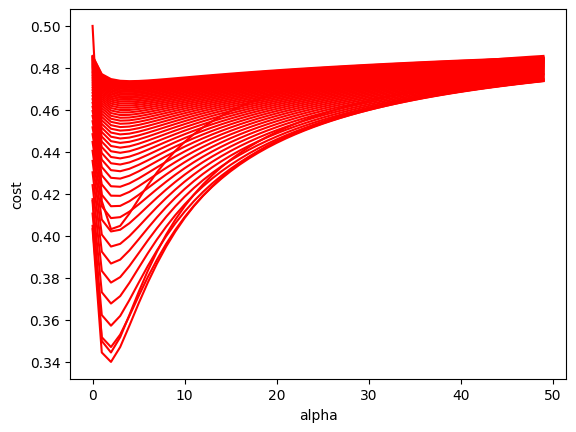

2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


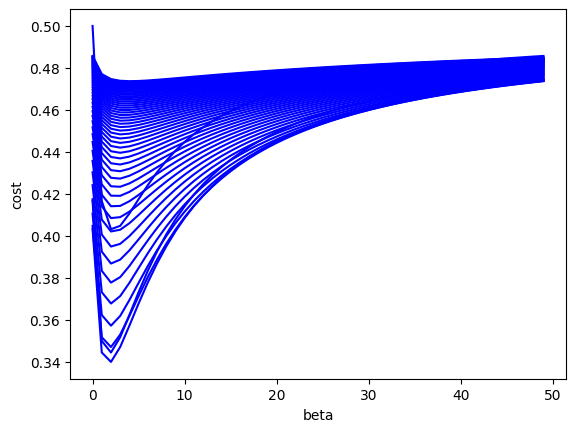

In [15]:
for i in range(Mx_val):
    plt.plot(np.arange(Mx_val),arr[i,:],'r-')
    plt.xlabel("alpha")
    plt.ylabel("cost")
    #plt.show()
    print(np.argmin(arr[i,:]))
plt.show()
for j in range(Mx_val):
    plt.plot(np.arange(Mx_val),arr[:,j],'b-')
    plt.xlabel("beta")
    plt.ylabel("cost")
    print(np.argmin(arr[:,j]))

Text(0.5, 0, 'cumulative-cost')

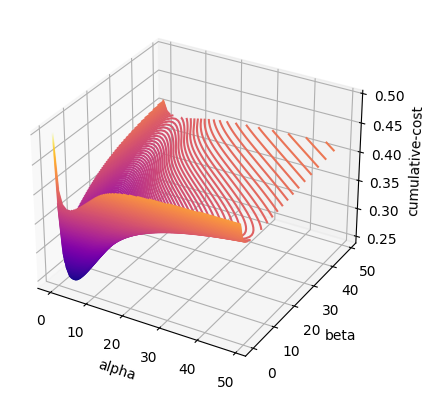

In [22]:
fig = plt.figure()
ax = plt.axes(projection='3d')  

ax.contour3D(np.arange(Mx_val), np.arange(Mx_val), arr, 200, cmap='plasma')
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_zlabel('cumulative-cost')


In [ ]:
#will the infinite solution work for finite cases::


In [6]:
#checking the assumption @1
#--> optimal alpha and beta are independent of each other::
cond=True
for i in range(arr.shape[0]):
    idx=np.argmin(arr[i])
    cond=cond and (idx+1==beta)
    print(idx+1,beta)
    print("-----------")
print("<><><><><><><><><>")
for i in range(arr.shape[1]):
    idx=np.argmin(arr[:,i])
    cond=cond and (idx+1==alpha)
    print(idx+1,alpha)
    print("----------")
print(cond)
#assumption turns out to be false::

4 4
-----------
4 4
-----------
4 4
-----------
4 4
-----------
5 4
-----------
5 4
-----------
5 4
-----------
5 4
-----------
5 4
-----------
6 4
-----------
<><><><><><><><><>
2 2
----------
2 2
----------
2 2
----------
2 2
----------
2 2
----------
2 2
----------
2 2
----------
2 2
----------
2 2
----------
2 2
----------
False
